### Optimal Transport

#### a. VoxCeleb1



In [86]:
import torch
import numpy as np
import kaldiio
from kaldiio import ReadHelper

import torch
import torch.utils.data as data
import os
import matplotlib.pyplot as plt

import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

from matplotlib.collections import PolyCollection
from scipy.interpolate import make_interp_spline
from scipy import stats

In [206]:
script_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/local/project/lstm_speaker_verification'

kwargs = {'num_workers': 8, 'pin_memory': False}
# /home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/logits/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456

solors = ['#fff7f5', '#fff3f0', '#ffefeb', '#ffebe6', '#fee7e0', '#fee3db', '#fedfd6', '#fedcd1', '#fed8cc', '#fed4c7', '#fed0c2', '#feccbd', '#fec8b8', '#fec4b3', '#fdc0ad', '#fdbca8', '#fdb8a3', '#fdb49e', '#fdb099', '#fdac94', '#fda88f', '#fda48a', '#fda085', '#fd9d80', '#fc997a', '#fc9575', '#fc9170', '#fc8d6b', '#fc8966', '#fc8561', '#fc815c', '#fc7d57', '#fc7952', '#fc754d', '#fb7147', '#fb6d42', '#fb693d', '#fb6538', '#fb6133', '#fb5d2e', '#fb5a29', '#fb5624', '#fb521f', '#fb4e19', '#fa4a14', '#fa460f', '#fa420a', '#fa3e05', '#fa3a00', '#f53900', '#f03800', '#eb3700', '#e63500', '#e13400', '#dc3300', '#d73200', '#d23100', '#cd3000', '#c82e00', '#c32d00', '#be2c00', '#b92b00', '#b42a00', '#af2900', '#aa2700', '#a52600', '#a02500', '#9b2400', '#962300', '#912200', '#8c2000', '#871f00', '#821e00', '#7d1d00', '#781c00', '#731b00', '#6e1a00', '#691800', '#641700', '#5f1600', '#5a1500', '#551400', '#501300', '#4b1100', '#461000', '#410f00', '#3c0e00', '#370d00']

solors2 = ['#f7f9f9', '#f3f6f5', '#eef3f2', '#eaf0ef', '#e6edec', '#e2e9e9', '#dee6e5', '#dae3e2', '#d6e0df', '#d1dddc', '#cddad9', '#c9d7d5', '#c5d4d2', '#c1d1cf', '#bdcecc', '#b9cbc9', '#b4c8c5', '#b0c4c2', '#acc1bf', '#a8bebc', '#a4bbb9', '#a0b8b5', '#9cb5b2', '#98b2af', '#93afac', '#8faca9', '#8ba9a5', '#87a6a2', '#83a39f', '#7fa09c', '#7b9c99', '#769995', '#729692', '#6e938f', '#6a908c', '#668d89', '#628a85', '#5e8782', '#59847f', '#55817c', '#517e79', '#4d7b75', '#497772', '#45746f', '#41716c', '#3c6e69', '#386b65', '#346862', '#30655f', '#2f635d', '#2e615b', '#2d5f59', '#2c5d57', '#2b5b56', '#2a5954', '#295752', '#285550', '#27534e', '#26514c', '#254f4a', '#244d48', '#244b46', '#234944', '#224743', '#214541', '#20433f', '#1f413d', '#1e3f3b', '#1d3d39', '#1c3b37', '#1b3935', '#1a3733', '#193531', '#183330', '#17302e', '#162e2c', '#152c2a', '#142a28', '#132826', '#122624', '#112422', '#102220', '#0f201e', '#0e1e1d', '#0d1c1b', '#0c1a19', '#0c1817', '#0b1615']

genres = ['advertisement', 'drama', 'entertainment', 'interview', 'live_broadcast', 'movie', 'play', 'recitation', 'singing', 'speech', 'vlog']

In [153]:
def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, ylist), (xlist[-1], 0.)]

def kurtoses(target_score):
    target_score = torch.tensor(target_score)

    diffs = target_score - target_score.mean()
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    z_scores = diffs / std

    kurtoses = torch.mean(torch.pow(z_scores, 4.0)) - 3.0
    
    return kurtoses

In [24]:
vox1_dir = 'ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456'

cnc1_dir = 'ThinResNet34/cnceleb/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_core/percent0.5_random/123456'

spk2idx = {}

for this_dir in [vox1_dir, cnc1_dir]:
    idx_file = script_dir + '/' + 'Data/logits/' + this_dir+ '/idx2spk'
    with open(idx_file, 'r') as f:
        for l in f.readlines():
            idx, spk= l.split()
            spk2idx[spk] = int(idx)

In [11]:
epochs = [i for i in range(1, 47)]
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
target_score_dict = {}
for i,epoch in enumerate(epochs):
    target_dict = {}
    xvector_path = 'Data/logits/' + vox1_dir+ '/vox1_dev_%d_fix/test/sim.ark.gz'%(epoch)
    with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
        for key, numpy_array in reader:
            spk = key.split('-')[0] # id00000-singing-01-001
            idx = spk2idx[spk]
            # print(idx)
            if idx in target_dict:
                target_dict[idx].append(numpy_array[idx])
            else:
                target_dict[idx] = [numpy_array[idx]]
    
    target_score = []
    for idx in target_dict:
        target_score.extend(target_dict[idx])
    
    target_score_dict[epoch] = target_score

In [25]:
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
target_score_dict2 = {}
for i,epoch in enumerate(epochs):
    target_dict = {}
    xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
    with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
        for key, numpy_array in reader:
            spk = key.split('-')[0] # id00000-singing-01-001
            idx = spk2idx[spk]
            # print(idx)
            if idx in target_dict:
                target_dict[idx].append(numpy_array[idx])
            else:
                target_dict[idx] = [numpy_array[idx]]
    
    target_score = []
    for idx in target_dict:
        target_score.extend(target_dict[idx])
    
    target_score_dict2[epoch] = target_score

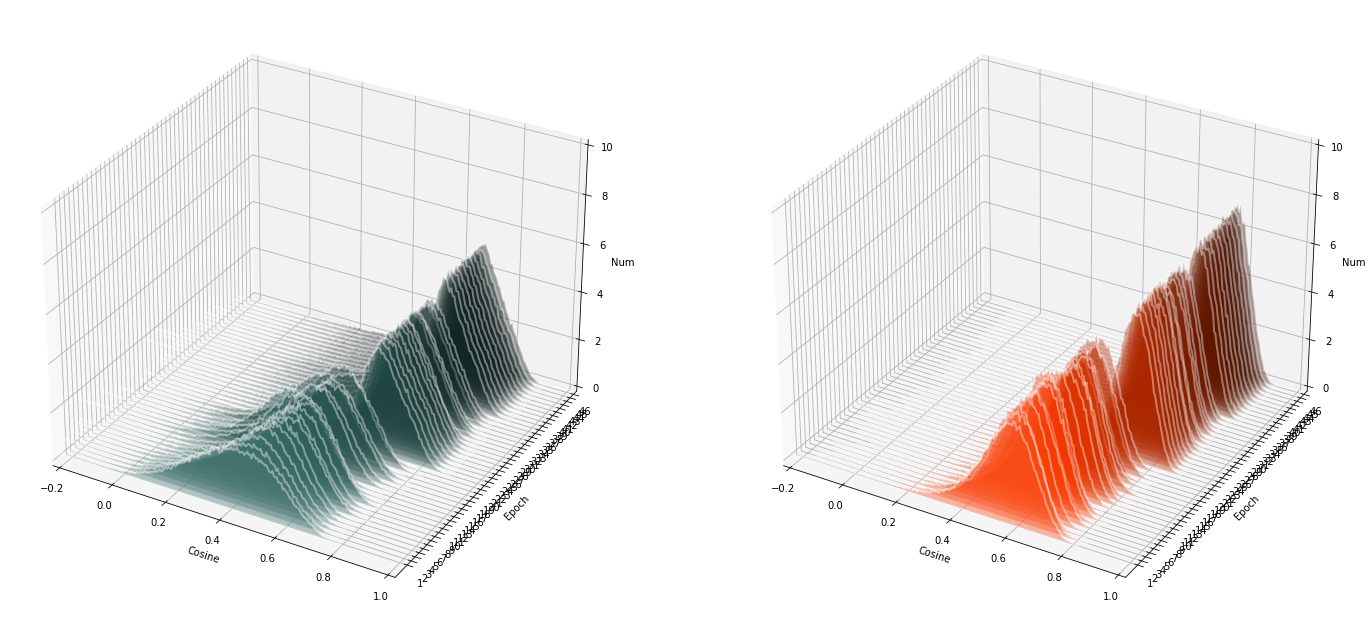

In [43]:
fig = plt.figure(figsize=(24, 12))

ax = fig.add_subplot(121, projection='3d')

# ax = plt.subplot(121).add_subplot(projection='3d')

# Make verts a list such that verts[i] is a list of (x, y) pairs defining polygon i.
# The ith polygon will appear on the plane y = zs[i]
zs = epochs
verts = []
for i, epoch in enumerate(epochs):
    target_score = target_score_dict2[epoch]
    hists, edgs = np.histogram(target_score, bins=200, density=True)
    # plt.bar((edgs[:-1]+edgs[1:])/2, hists, width=0.35, fill=False, edgecolor='orange')
    # plt.plot((edgs[:-1]+edgs[1:])/2, hists, fillstyle='bottom', gapcolor='orange')
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists

    verts.append(polygon_under_graph(xs, ys))

poly2 = PolyCollection(verts, facecolors=solors2[-len(verts):], edgecolors=("white",), alpha=.4, linewidths=2.0)
ax.add_collection3d(poly2, zs=[i-1 for i in zs], zdir='y')
ax.set_xlabel('Cosine')
ax.set_ylabel('Epoch')
ax.set_zlabel('Num')
ax.set_yticks(zs)
ax.set_xlim(-0.2, 1)
ax.set_ylim(-1, 46)
ax.set_zlim(0, 10)

ax = fig.add_subplot(122, projection='3d')
verts = []
for i, epoch in enumerate(epochs):
    target_score = target_score_dict[epoch]
    hists, edgs = np.histogram(target_score, bins=200, density=True)
    # plt.bar((edgs[:-1]+edgs[1:])/2, hists, width=0.35, fill=False, edgecolor='orange')
    # plt.plot((edgs[:-1]+edgs[1:])/2, hists, fillstyle='bottom', gapcolor='orange')
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists

    verts.append(polygon_under_graph(xs, ys))

poly = PolyCollection(verts, facecolors=solors[-len(verts):], edgecolors=("white",), alpha=.4, linewidths=2.0)
ax.add_collection3d(poly, zs=[i-1 for i in zs], zdir='y')

ax.set_xlabel('Cosine')
ax.set_ylabel('Epoch')
ax.set_zlabel('Num')
ax.set_yticks(zs)
ax.set_xlim(-0.2, 1)
ax.set_ylim(-1, 46)
ax.set_zlim(0, 10)

plt.show()

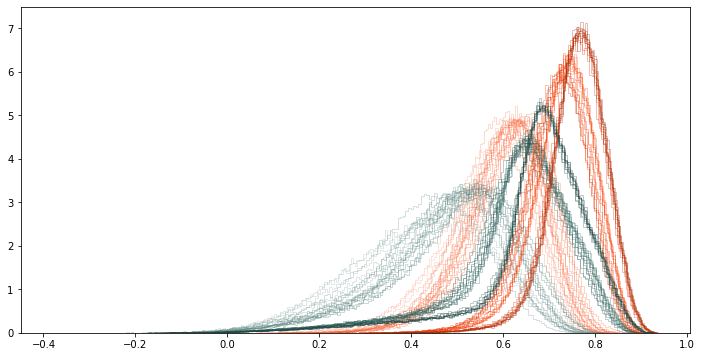

In [68]:
plt.figure(figsize=(12,6))
# fig, (ax1, ax2) = plt.subplots(2, 1)
for i,epoch in enumerate(epochs):
    target_score = target_score_dict[epoch]
    # plt.subplot(4, 1, int(i//5+1))
    _ = plt.hist(target_score, bins=200, histtype='step', color=solors[i+20], density=True, alpha=0.3)    
    target_score = target_score_dict2[epoch]
    _ = plt.hist(target_score, bins=200, histtype='step', color=solors2[i+20], density=True, alpha=0.3)

# ax2.invert_yaxis()

In [65]:
len(solors2)

88

In [ ]:
spk2idx

In [155]:
# epochs = [i for i in range(1, 47)]
epoch = 46
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
v_target_scores = []
v_nontarget_scores = []
xvector_path = 'Data/logits/' + vox1_dir+ '/vox1_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        idx = spk2idx[spk]
        v_target_scores.append(numpy_array[idx])
        v_nontarget_scores.extend(np.delete(numpy_array, idx))

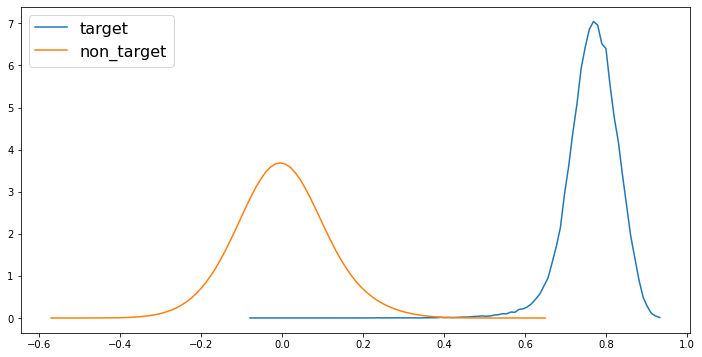

In [168]:
plt.figure(figsize=(12,6))
# fig, (ax1, ax2) = plt.subplots(2, 1)

for s in [v_target_scores, v_nontarget_scores]:
    hists, edgs = np.histogram(s, bins=100, density=True)
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists
    # ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
    plt.plot(xs, ys)

# ax2.invert_yaxis()
plt.legend(['target', 'non_target'], fontsize=16)

In [157]:
print('vox1: ' , float(kurtoses(v_target_scores)))

vox1:  3.9820899963378906


In [136]:
a = np.arange(12)
print(a)
print(np.delete(a, 0))

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 1  2  3  4  5  6  7  8  9 10 11]


In [137]:
# epochs = [i for i in range(1, 47)]
epoch = 46
# <= 20 0.1, <= 35 0.01, <= 45 0.001, == 46 0.0001
genre_target_score_dict = {}
genre_nontarget_score_dict = {}

for g in genres:
    genre_target_score_dict[g] = []
    genre_nontarget_score_dict[g] = []
    
# target_dict = {}
xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        g = key.split('-')[1]
        idx = spk2idx[spk]
        # print(idx)
        genre_target_score_dict[g].append(numpy_array[idx])
        genre_nontarget_score_dict[g].extend(np.delete(numpy_array, idx))

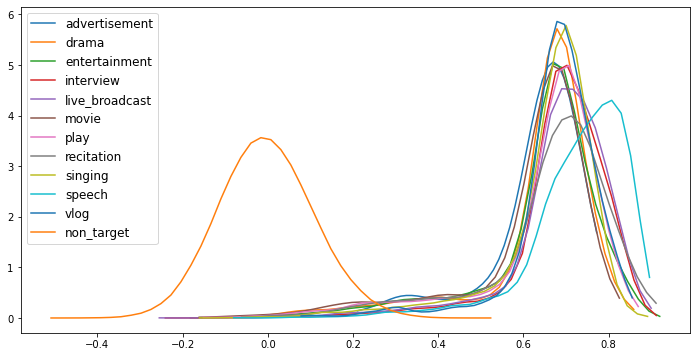

In [170]:
plt.figure(figsize=(12,6))
# fig, (ax1, ax2) = plt.subplots(2, 1)
legends = []
for i,g in enumerate(genres):
    target_score = genre_target_score_dict[g]
    legends.append(g)
    # plt.subplot(4, 1, int(i//5+1))
    # _ = plt.hist(target_score, bins=50, histtype='step', density=True, alpha=1) 
    hists, edgs = np.histogram(target_score, bins=45, density=True)
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists
    ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
    plt.plot(xs, ys)
    
target_score = genre_nontarget_score_dict[g]
legends.append('non_target')

hists, edgs = np.histogram(target_score, bins=45, density=True)
xs, ys= (edgs[:-1]+edgs[1:])/2, hists
ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
plt.plot(xs, ys)
    
# ax2.invert_yaxis()
plt.legend(legends, fontsize=12)

 advertisement: 0.0113
         drama: 0.0047
 entertainment: 0.0048
     interview: 0.0051
live_broadcast: 0.0032
         movie: 0.0054
          play: 0.0121
    recitation: 0.0112
       singing: 0.0078
        speech: 0.0056
          vlog: 0.0028
          vox1: 0.0048


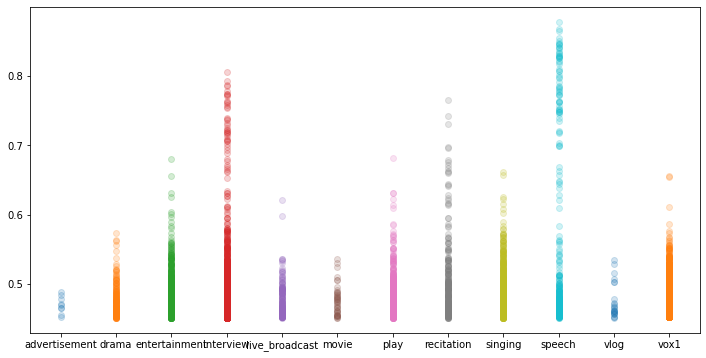

In [203]:
plt.figure(figsize=(12,6))

numoftimes = 4
c_mean = np.mean(c_nontarget_score)
c_std = np.std(c_nontarget_score)

for i,g in enumerate(genres):
    target_score = np.array(genre_nontarget_score_dict[g])
    over_scores = target_score[np.where(target_score>(c_mean+4*c_std))[0]]
    
    if len(over_scores)>0:
        print("{:>14}: {:.4f}".format(g, (len(over_scores)/len(target_score))*100))
    
    plt.scatter([g]*len(over_scores), over_scores, alpha=0.2)

v_mean = np.mean(v_nontarget_scores)
v_std = np.std(v_nontarget_scores)

target_score = np.array(v_nontarget_scores)
over_scores = target_score[np.where(target_score>(v_mean+4*v_std))[0]]
plt.scatter(['vox1']*len(over_scores), over_scores, alpha=0.2)
print("{:>14}: {:.4f}".format('vox1', (len(over_scores)/len(target_score))*100))
# plt.legend(legends, fontsize=12)

In [220]:
numoftimes = 4
c_mean = np.mean(c_nontarget_score)
c_std = np.std(c_nontarget_score)
v_mean = np.mean(v_nontarget_scores)
v_std = np.std(v_nontarget_scores)
v_nontarget_score = np.array(v_nontarget_scores)

xs = genres.copy()
xs.append('vox1')

/tmp/ipykernel_1016802/3313062315.py:9: RuntimeWarning: divide by zero encountered in log
  ys.append(np.log(len(over_scores)/len(target_score)*100))


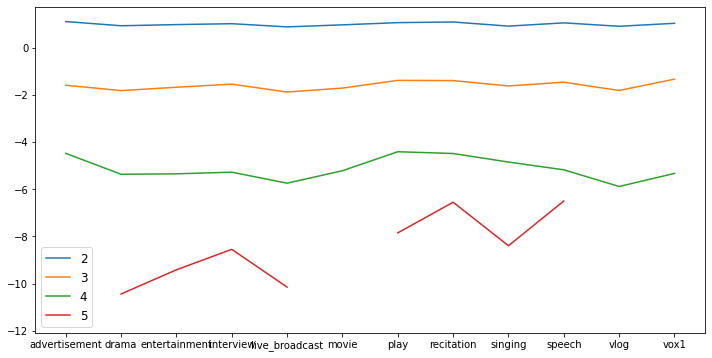

In [229]:
plt.figure(figsize=(12,6))

for numoftimes in [2, 3, 4, 5]:
    ys = []
    for i,g in enumerate(genres):
        target_score = np.array(genre_nontarget_score_dict[g])
        over_idx = np.where(target_score>(c_mean+numoftimes*c_std))[0]
        over_scores = target_score[over_idx]
        ys.append(np.log(len(over_scores)/len(target_score)*100))
        # ys.append(np.mean(over_scores))

    over_scores = v_nontarget_score[np.where(v_nontarget_score>(v_mean+numoftimes*v_std))[0]]
    ys.append(np.log(len(over_scores)/len(v_nontarget_score)*100))
    # ys.append(np.mean(over_scores))
    plt.plot(xs, ys)
    
plt.legend([2, 3, 4, 5], fontsize=12)

In [194]:
c_mean+6*c_std

0.6771754618966952

In [161]:
# fig, (ax1, ax2) = plt.subplots(2, 1)
c_target_score = []
c_nontarget_score = []

for i,g in enumerate(genres):
    c_target_score.extend(genre_target_score_dict[g])
    c_nontarget_score.extend(genre_nontarget_score_dict[g])

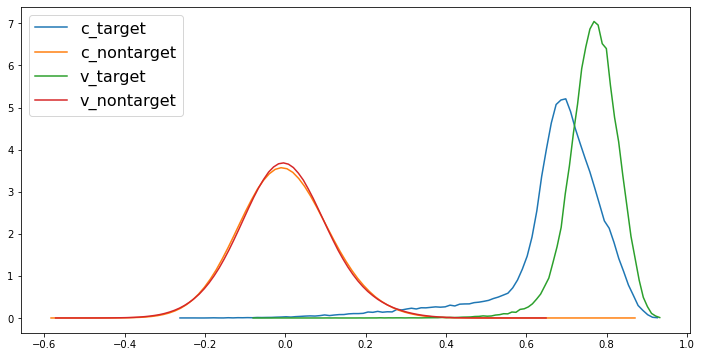

In [171]:
plt.figure(figsize=(12,6))

for scores in [c_target_score, c_nontarget_score, v_target_scores, v_nontarget_scores]:
    hists, edgs = np.histogram(scores, bins=100, density=True)
    xs, ys= (edgs[:-1]+edgs[1:])/2, hists
    # ys = stats.gaussian_kde(target_score, bw_method='scott')(xs)
    plt.plot(xs, ys)

# ax2.invert_yaxis()
plt.legend(['c_target', 'c_nontarget', 'v_target', 'v_nontarget'], fontsize=16)

In [165]:
print('cnc1: {:>.4f}'.format(kurtoses(c_target_score)))
print('vox1: {:>.4f}'.format(kurtoses(v_target_scores)))

cnc1: 5.6059
vox1: 3.9821


In [121]:
for i,g in enumerate(genres):
    target_score = genre_target_score_dict[g]
    print('{:.4f}, '.format(np.mean(target_score)), end='')

0.6318, 0.6312, 0.6409, 0.6850, 0.6853, 0.6124, 0.6429, 0.6582, 0.6544, 0.7296, 0.6761, 

In [122]:
epoch = 46
spk2genres = {}

xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        g = key.split('-')[1]
        
        idx = spk2idx[spk]
        # print(idx)
        if spk in spk2genres:
            spk2genres[spk].add(g)
        else:
            spk2genres[spk] = set([g])

In [123]:
numofg2spk = {}
for i in range(1, 12):
    numofg2spk[i] = []
    
for spk in spk2genres:
    numofg2spk[len(spk2genres[spk])].append(spk)

In [132]:
numofg2spk[6]

['id00406']

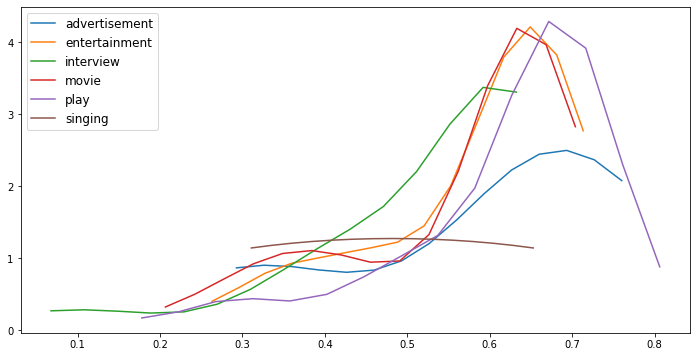

In [172]:
epoch = 46
this_spk = 'id00406'#'id00491'
skp_score_dict = {}
for g in genres:
    skp_score_dict[g] = []

xvector_path = 'Data/logits/' + cnc1_dir+ '/cnceleb_dev_%d_fix/test/sim.ark.gz'%(epoch)
with ReadHelper('ark: gunzip -c %s |'%(script_dir+'/'+ xvector_path)) as reader:
    for key, numpy_array in reader:
        spk = key.split('-')[0] # id00000-singing-01-001
        if spk == this_spk:
            g = key.split('-')[1]
            idx = spk2idx[spk]
            skp_score_dict[g].append(numpy_array[idx])
            
plt.figure(figsize=(12, 6))
# fig, (ax1, ax2) = plt.subplots(2, 1)
legends = []
for i,g in enumerate(skp_score_dict):
    target_score = skp_score_dict[g]
    if len(target_score) > 0:
        legends.append(g)
        hists, edgs = np.histogram(target_score, bins=15, density=True)
        xs, ys= (edgs[:-1]+edgs[1:])/2, hists
        plt.plot(xs, stats.gaussian_kde(target_score, bw_method='scott')(xs))
# ax2.invert_yaxis()
plt.legend(legends, fontsize=12)